In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
import elevation
import elevation.prediction_pipeline as pp
from IPython.core.debugger import Tracer
import matplotlib.pyplot as plt
np.random.seed(123) 
import scipy.stats as st
import pickle
#import seaborn
import matplotlib
import azimuth.util

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
colors = ['#ca0020', '#f4a582', '#ffffbf', '#92c5de', '#0571b0']
background_color = '#EAEAF2'

plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22
plt.rcParams['axes.labelsize'] = 26
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['font.family'] = 'Segoe UI'
plt.rcParams['xtick.major.size'] = 0
plt.rcParams['xtick.minor.size'] = 0
plt.rcParams['ytick.major.size'] = 0
plt.rcParams['ytick.minor.size'] = 0
plt.rcParams['axes.edgecolor'] = 'white'

methods_colors = {'CFD': '#f4a582',
                 'HsuZhang': '#92c5de',
                 'CCTOP': "#0571b0",
                 'Elevation': '#ca0020',
                 'Elevation-naive': '#92c5de'}

methods_names = {'CFD': 'CFD',
                'HsuZhang': 'HsuZhang',
                'CCTOP': 'CCTOP',
                'linear-raw-stacker': 'Elevation',
                'product': 'Elevation-naive'}

In [3]:
np.random.seed(123)
learn_options = {'num_proc': 10,
                     'nuc_features_WT': False, 'include_pi_nuc_feat': False,
                     'annotation position one-hot': False,
                     'mutation_type' : False,
                     'annotation_onehot' : True, # featurize like CFD
                     'annotation_decoupled_onehot' : ['pos', 'let', 'transl'], # decouple the CFD features into letters and position                    
                     "include_Tm": False,
                     'include_azimuth_score': None, # all of them ["WT","MUT","DELTA"]
                     'azimuth_feat' : None, # was: ['WT']
                     "include_gene_position": False,
                     "cv": "stratified",
                     'adaboost_loss' : 'ls',
                     'adaboost_CV': False, "algorithm_hyperparam_search" : "grid",
                     'n_folds' : 10,
                     'allowed_category' : None,#"Mismatch",#"Insertion",
                     "include_NGGX_interaction": False,
                     'normalize_features' : False, 'class_weight': None,
                     "phen_transform": 'kde_cdf', #  'kde_cdf',
                     "training_metric": 'spearmanr',
                     "fit_intercept" : True,
                     "seed" : 12345,
                     "num_proc": 1,
                     "alpha": np.array([1.0e-3]),
                     "V": "CD33", 
                     "left_right_guide_ind": [4,27,30], # 21-mer
                     "order": 1,
                     "testing_non_binary_target_name": 'ranks',
                     'models': ["AdaBoost"],
                     'post-process Platt': False,
                     'azimuth_score_in_stacker': False,
                     'guide_seq_full': True,
                     'use_mut_distances': False,
                     'reload guideseq': False,
                     "renormalize_guideseq": True,
}

# Pickling 

In [4]:
base_model, fnames = pp.train_base_model(learn_options) 
guideseq_data = pp.load_guideseq(learn_options, filterPAMs=False, subsample_zeros=False) 

hmg = elevation.load_data.load_hauessler_minus_guideseq()
hmg['GUIDE-SEQ Reads'] = hmg['readFraction'].copy()

# preds_guideseq = pp.predict_guideseq(base_model, guideseq_data, learn_options,  naive_bayes_combine=True)
with open('../elevation/guideseq_all_zeros_pred.pickle', 'rb') as f:
    preds_guideseq, learn_options_p = pickle.load(f)
    
# nb_pred_hmg, individual_mut_pred_hmg = pp.predict(base_model, hmg, learn_options)
with open('/tmp/trainhu_gs.pickle', 'rb') as f:
    individual_mut_pred_hmg = pickle.load(f)
    
roc_data, roc_Y_bin, roc_Y_vals = elevation.load_data.load_HauesslerFig2();
nb_pred_roc, individual_mut_pred_roc = pp.predict(base_model, roc_data, learn_options)

cd33_data = elevation.load_data.load_cd33(learn_options)[0]
cd33_data['Annotation'] = cd33_data['Annotation'].apply(lambda x: [x])

# with open('../elevation/calibration_models.pickle', 'rb') as f:
#    calibration_models = pickle.load(f)

Received option CV=False, so I'm training using all of the data
running AdaBoost, order 1 for final
MKL not available, so I'm not adjusting the number of threads
Launching 1 jobs with 1 MKL threads each
loading processed data from file: ../../data/offtarget/CD33.processed.[4, 27, 30].pamfiltTrue.p...
done.
{'bandwidth': 0.23000000000000001}
featurizing data...
done.
range of y_all is [0.000002, 1.000000]
filename = VCD33AdaBoostRegressor.order1Day21-ETP.gene.spearman
Cross-validating genes...
		RMSE:  0.234899630773
		Spearman correlation:  0.629531672039
		finished fold/gene 1 of 1
		median spearmanr across gene folds: 0.630
		Elapsed time for cv is 1.85 seconds
loading GuideSeq data from pickle...
done.
Done.
loading GuideSeq data from pickle...
done.
Done.
loading processed data from file: ../../data/offtarget/CD33.processed.[4, 27, 30].pamfiltTrue.p...
done.
{'bandwidth': 0.23000000000000001}


In [45]:
# nb_pred_hmg, individual_mut_pred_hmg = pp.predict(base_model, hmg, learn_options)

In [46]:
with open('../elevation/guideseq_all_zeros_pred.pickle', 'wb') as f:
    pickle.dump((preds_guideseq, learn_options), f)

with open('/tmp/trainhu_gs.pickle', 'wb') as f:
    pickle.dump(individual_mut_pred_hmg, f)

In [15]:
to_be_calibrated = ['linear-raw-stacker']
calibration_models = {}

for m in to_be_calibrated:
    calibration_models[m] = pp.train_prob_calibration_model(cd33_data, guideseq_data, preds_guideseq, 
                                                            base_model, learn_options, which_model=m,
                                                            other_calibration_models=calibration_models)

with open('../elevation/calibration_models.pickle', 'wb') as f:
    pickle.dump(calibration_models, f)

/mnt/projects_drive/projects/CRISPR/code/elevation/elevation/prediction_pipeline.py:381: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ind_keep[ind_zero[::ind_zero.shape[0]/float(ind_keep.sum())]] = True
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Train on Guide-seq predict on Haeussler

In [127]:
pred_roc_calibrated, stacker_gs, feat_gs = pp.stacked_predictions(roc_data, individual_mut_pred_roc, learn_options=learn_options, 
                                       guideseq_data=guideseq_data,
                                       preds_guideseq=preds_guideseq, 
                                       prob_calibration_model=calibration_models,
                                       models=['product', 'linear-raw-stacker', 'CFD', 'HsuZhang', 'CCTOP'],
                                       return_model=True, return_residuals=False)

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [128]:
data_c = np.concatenate((np.array(pred_roc_calibrated['CFD']).flatten()[:, None], 
                np.array(pred_roc_calibrated['linear-raw-stacker']).flatten()[:, None]), axis=1)[:100]
df = pd.DataFrame(data=data_c, columns=['CFD', 'linear-raw-stacker'])
print df
#df.to_excel('regression_test.xls')

         CFD  linear-raw-stacker
0   0.006568            0.001013
1   0.018194            0.000889
2   0.148423            0.008645
3   0.005546            0.000813
4   0.063281            0.002104
5   0.016559            0.000834
6   0.002571            0.000515
7   0.037025            0.001086
8   0.001331            0.000818
9   0.016806            0.001501
10  0.003183            0.001205
11  0.012760            0.001307
12  0.054012            0.000830
13  0.026471            0.001111
14  0.102564            0.001982
15  0.054299            0.001219
16  0.006835            0.001145
17  0.002711            0.000558
18  0.049653            0.001049
19  0.050000            0.001233
20  0.143590            0.003267
21  0.025747            0.001801
22  0.001152            0.000615
23  0.000000            0.000326
24  0.050154            0.001270
25  0.000000            0.001177
26  0.044938            0.000506
27  0.018234            0.000979
28  0.050870            0.001430
29  0.0036

CCTOP
product
CFD
linear-raw-stacker
HsuZhang


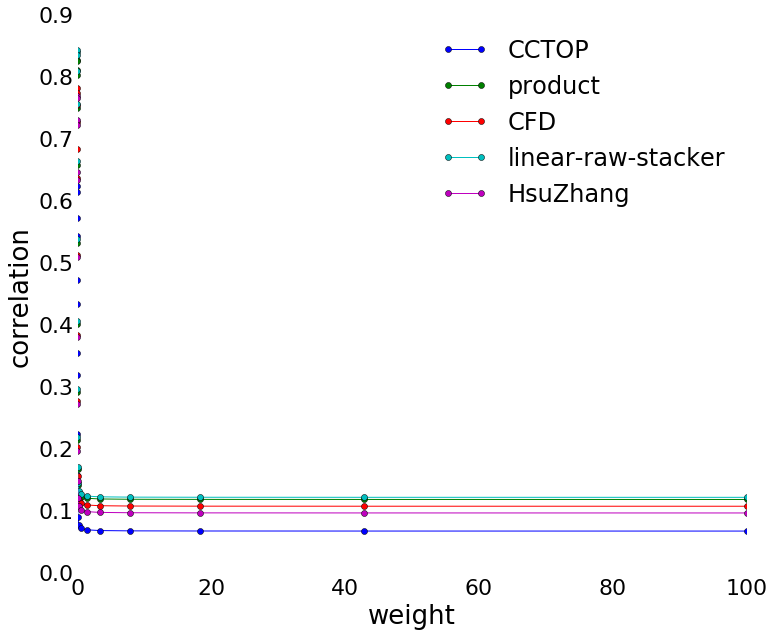

In [19]:
roc_results = pp.plot_spearman_with_different_weights(pred_roc_calibrated, roc_Y_vals.values.flatten(), 
                                                      weights=np.logspace(np.log10(0.00001), np.log10(100), 20))

In [236]:
import elevation.metrics

def pv_weighted_spearman(pred1, pred2, truth, weights):
    pvs = []
    for w in weights:
        weights_array = truth.copy()
        weights_array += w
        pv = elevation.metrics.spearman_weighted_swap_perm_test(pred1, pred2, truth, 10, weights_array)[0]
        pvs.append(pv)
    return pvs|

#roc_pvs = pv_weighted_spearman(pred_roc_calibrated['ensemble'], 
#                               pred_roc_calibrated['CFD'], 
#                               roc_Y_vals.values.flatten(),  
#                               weights=np.logspace(np.log10(0.00001), np.log10(100), 1))

In [221]:
with open('/tmp/roc.pickle', 'wb') as f:
    pickle.dump((pred_roc_calibrated, roc_Y_vals), f)

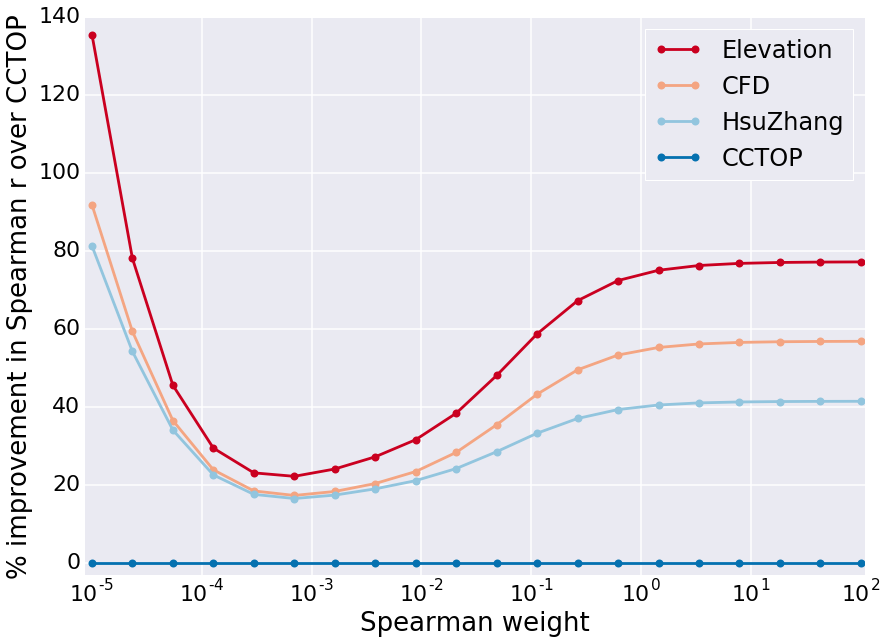

In [42]:
fig = plt.figure(figsize=(14, 10))

x = np.logspace(np.log10(0.00001), np.log10(100), 20)
for m in ['linear-raw-stacker', 'CFD', 'HsuZhang', 'CCTOP']:
    plt.plot(x, ((np.array(roc_results[m]) -np.array(roc_results['CCTOP']))/np.array(roc_results['CCTOP']))*100., 'o-', 
             label=methods_names[m], color=methods_colors[methods_names[m]], markeredgewidth=0.0, linewidth=2.8, markersize=8)
plt.xscale('log')

# background color
ax = plt.gca()
ax.patch.set_facecolor(background_color)

# grid
plt.grid(color='#ffffff', linestyle='-', linewidth=1.5)
ax.set_axisbelow(True)
a = ax.get_xgridlines()
a[2].set_color(background_color)
a[-1].set_color(background_color)


# legend
plt.legend(loc=0)
lh = ax.get_legend()
lh.legendPatch.set_facecolor(background_color)


plt.ylim(-3., 140)
x_lims = plt.xlim()
plt.xlim((8.5e-6, 1.10*x_lims[1]))

plt.ylabel('% improvement in Spearman r over CCTOP')
plt.xlabel('Spearman weight')
plt.savefig('plots/improvement_over_CCTOP_Haeussler_trainingGuideseq.pdf')
# plt.title("Haeussler minus GUIDE-Seq")

In [61]:
t2, pv, corr0, corr1,_ = azimuth.util.get_pval_from_predictions(pred_roc_calibrated['linear-raw-stacker'], 
                                                       pred_roc_calibrated['CFD'],  
                                                       roc_Y_vals.values.flatten(), 
                                                       twotailed=False, method='steiger')
print pv, corr0, corr1

0.00352780509056 0.124903533749 0.11054902691


In [108]:
for method in pred_roc_calibrated.keys():
    print method, "Spearman=%f, pv=%f" % st.spearmanr(pred_roc_calibrated[method], roc_Y_vals.values.flatten())

CCTOP Spearman=0.070499, pv=0.000000
product Spearman=0.121457, pv=0.000000
CFD Spearman=0.110549, pv=0.000000
linear-raw-stacker Spearman=0.124904, pv=0.000000
HsuZhang Spearman=0.099706, pv=0.000000


# Train on Haeussler predict on Guide-seq

In [44]:
pred_guideseq_hmg, stacker_hmg, feat_hmg = pp.stacked_predictions(guideseq_data, preds_guideseq, guideseq_data=hmg,
                                            preds_guideseq=individual_mut_pred_hmg,
                                            prob_calibration_model=calibration_models,
                                            learn_options=learn_options,
                                            models=['linear-raw-stacker','product', 'CFD', 'HsuZhang','CCTOP'],
                                            return_model=True,
                                            )

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CCTOP
product
CFD
linear-raw-stacker
HsuZhang


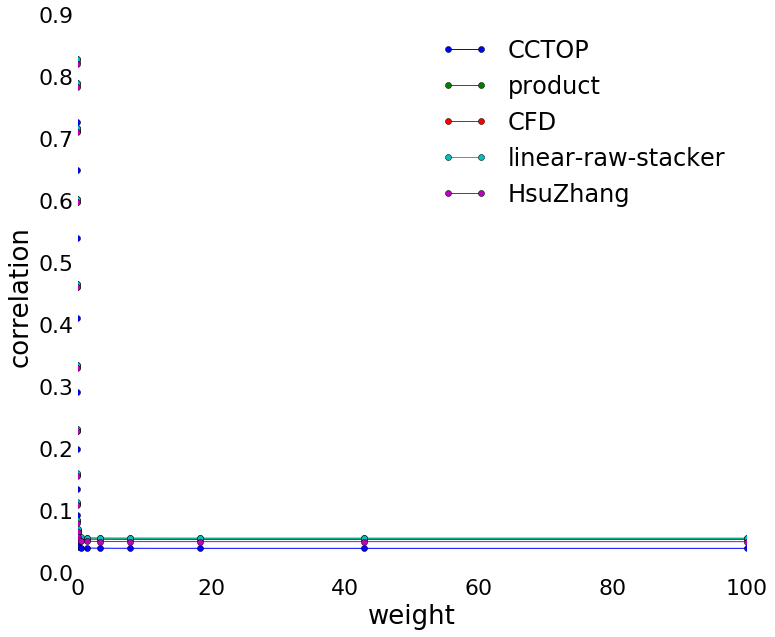

In [45]:
gs_results_hmg = pp.plot_spearman_with_different_weights(pred_guideseq_hmg, guideseq_data['GUIDE-SEQ Reads'].values.flatten(), 
                                                      weights=np.logspace(np.log10(0.00001), np.log10(100), 20))

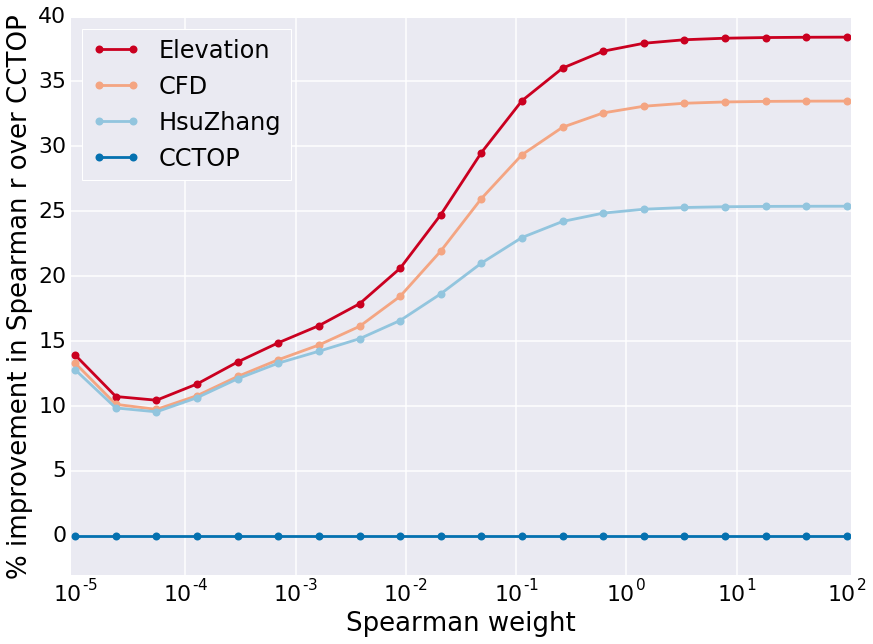

In [47]:
fig = plt.figure(figsize=(14, 10))

x = np.logspace(np.log10(0.00001), np.log10(100), 20)
for m in ['linear-raw-stacker', 'CFD', 'HsuZhang','CCTOP']:
    plt.plot(x, ((np.array(gs_results_hmg[m]) -np.array(gs_results_hmg['CCTOP']))/np.array(gs_results_hmg['CCTOP']))*100., 'o-', 
             label=methods_names[m], color=methods_colors[methods_names[m]], markeredgewidth=0.0, linewidth=2.8, markersize=8)
plt.xscale('log')

# background color
ax = plt.gca()
ax.patch.set_facecolor(background_color)

# grid
plt.grid(color='#ffffff', linestyle='-', linewidth=1.5)
ax.set_axisbelow(True)
a = ax.get_xgridlines()
a[2].set_color(background_color)
a[-1].set_color(background_color)
# legend
plt.legend(loc=0)
lh = ax.get_legend()
lh.legendPatch.set_facecolor(background_color)


# plt.ylim(-0.95, 100)
plt.ylim(-3., 40)
x_lims = plt.xlim()
plt.xlim((9.0e-6, 1.10*x_lims[1]))

plt.ylabel('% improvement in Spearman r over CCTOP')
plt.xlabel('Spearman weight')

plt.savefig('plots/improvement_over_CCTOP_Guideseq_trainingonHaeussler.pdf')

In [60]:
t2, pv, corr0, corr1,_ = azimuth.util.get_pval_from_predictions(pred_guideseq_hmg['linear-raw-stacker'], 
                                                       pred_guideseq_hmg['CFD'],  
                                                       guideseq_data['GUIDE-SEQ Reads'].values.flatten(), 
                                                       twotailed=False, method='steiger')
print pv, corr0, corr1

0.0945909807993 0.059021367141 0.0569209882995


In [109]:
for method in pred_roc_calibrated.keys():
    print method, "Spearman=%f, pv=%f" % st.spearmanr(pred_guideseq_hmg[method], guideseq_data['GUIDE-SEQ Reads'].values.flatten())

CCTOP Spearman=0.042638, pv=0.000000
product Spearman=0.058764, pv=0.000000
CFD Spearman=0.056921, pv=0.000000
linear-raw-stacker Spearman=0.059021, pv=0.000000
HsuZhang Spearman=0.053465, pv=0.000000


# Cross-validation on Guide-seq

In [151]:
pred_gs, perf_gs, mismatches_gs, truth_gs, _, _ = pp.cross_validate_guideseq(guideseq_data,
                                                                            preds_guideseq,
                                                                            learn_options,
       models= ['CCTOP', 'product', 'linear-raw-stacker'], n_folds=100)

predictions_flat = dict([(k, np.concatenate(pred_gs[k]).flatten()) for k in pred_gs.keys()])
truth_all = np.concatenate(truth_gs).flatten()

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 1, Spearman r: product=0.064 linear-raw-stacker=0.064 CCTOP=0.058 
Fold 1, NDCG k ties: product=0.999 linear-raw-stacker=0.999 CCTOP=0.993 
Fold 2, Spearman r: product=0.064 linear-raw-stacker=0.064 CCTOP=0.054 
Fold 2, NDCG k ties: product=0.496 linear-raw-stacker=0.513 CCTOP=0.145 
Fold 3, Spearman r: product=0.063 linear-raw-stacker=0.063 CCTOP=0.033 
Fold 3, NDCG k ties: product=0.267 linear-raw-stacker=0.499 CCTOP=0.094 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 4, Spearman r: product=0.063 linear-raw-stacker=0.064 CCTOP=0.047 
Fold 4, NDCG k ties: product=0.955 linear-raw-stacker=0.974 CCTOP=0.938 
Fold 5, Spearman r: product=0.064 linear-raw-stacker=0.064 CCTOP=0.061 
Fold 5, NDCG k ties: product=0.926 linear-raw-stacker=0.919 CCTOP=0.453 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 6, Spearman r: product=0.063 linear-raw-stacker=0.063 CCTOP=0.046 
Fold 6, NDCG k ties: product=0.970 linear-raw-stacker=0.973 CCTOP=0.212 
Fold 7, Spearman r: product=0.062 linear-raw-stacker=0.063 CCTOP=0.050 
Fold 7, NDCG k ties: product=0.687 linear-raw-stacker=0.701 CCTOP=0.161 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 8, Spearman r: product=0.063 linear-raw-stacker=0.064 CCTOP=0.048 
Fold 8, NDCG k ties: product=0.999 linear-raw-stacker=0.999 CCTOP=0.120 
Fold 9, Spearman r: product=0.063 linear-raw-stacker=0.064 CCTOP=0.053 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 9, NDCG k ties: product=0.994 linear-raw-stacker=0.992 CCTOP=0.986 
Fold 10, Spearman r: product=0.064 linear-raw-stacker=0.064 CCTOP=0.047 
Fold 10, NDCG k ties: product=0.947 linear-raw-stacker=0.956 CCTOP=0.916 
Fold 11, Spearman r: product=0.064 linear-raw-stacker=0.064 CCTOP=0.047 
Fold 11, NDCG k ties: product=0.970 linear-raw-stacker=0.907 CCTOP=0.414 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 12, Spearman r: product=0.063 linear-raw-stacker=0.063 CCTOP=0.028 
Fold 12, NDCG k ties: product=0.862 linear-raw-stacker=0.585 CCTOP=0.129 
Fold 13, Spearman r: product=0.062 linear-raw-stacker=0.062 CCTOP=0.048 
Fold 13, NDCG k ties: product=0.163 linear-raw-stacker=0.175 CCTOP=0.120 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 14, Spearman r: product=0.061 linear-raw-stacker=0.062 CCTOP=0.048 
Fold 14, NDCG k ties: product=0.783 linear-raw-stacker=0.585 CCTOP=0.208 
Fold 15, Spearman r: product=0.062 linear-raw-stacker=0.063 CCTOP=0.053 
Fold 15, NDCG k ties: product=0.448 linear-raw-stacker=0.515 CCTOP=0.169 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 16, Spearman r: product=0.062 linear-raw-stacker=0.064 CCTOP=0.040 
Fold 16, NDCG k ties: product=0.824 linear-raw-stacker=0.830 CCTOP=0.408 
Fold 17, Spearman r: product=0.062 linear-raw-stacker=0.062 CCTOP=0.050 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 17, NDCG k ties: product=0.988 linear-raw-stacker=0.995 CCTOP=0.995 
Fold 18, Spearman r: product=0.062 linear-raw-stacker=0.064 CCTOP=0.057 
Fold 18, NDCG k ties: product=0.518 linear-raw-stacker=0.571 CCTOP=0.141 
Fold 19, Spearman r: product=0.062 linear-raw-stacker=0.063 CCTOP=0.036 
Fold 19, NDCG k ties: product=0.651 linear-raw-stacker=0.536 CCTOP=0.139 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 20, Spearman r: product=0.064 linear-raw-stacker=0.064 CCTOP=0.061 
Fold 20, NDCG k ties: product=0.815 linear-raw-stacker=0.795 CCTOP=0.766 
Fold 21, Spearman r: product=0.063 linear-raw-stacker=0.064 CCTOP=0.050 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 21, NDCG k ties: product=0.896 linear-raw-stacker=0.907 CCTOP=0.141 
Fold 22, Spearman r: product=0.063 linear-raw-stacker=0.063 CCTOP=0.023 
Fold 22, NDCG k ties: product=0.959 linear-raw-stacker=0.961 CCTOP=0.182 
Fold 23, Spearman r: product=0.055 linear-raw-stacker=0.046 CCTOP=0.024 
Fold 23, NDCG k ties: product=0.388 linear-raw-stacker=0.492 CCTOP=0.112 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 24, Spearman r: product=0.061 linear-raw-stacker=0.063 CCTOP=0.034 
Fold 24, NDCG k ties: product=0.297 linear-raw-stacker=0.986 CCTOP=0.115 
Fold 25, Spearman r: product=0.063 linear-raw-stacker=0.063 CCTOP=0.020 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 25, NDCG k ties: product=0.352 linear-raw-stacker=0.373 CCTOP=0.114 
Fold 26, Spearman r: product=0.064 linear-raw-stacker=0.063 CCTOP=0.046 
Fold 26, NDCG k ties: product=0.972 linear-raw-stacker=0.974 CCTOP=0.604 
Fold 27, Spearman r: product=0.062 linear-raw-stacker=0.063 CCTOP=0.043 
Fold 27, NDCG k ties: product=0.994 linear-raw-stacker=0.995 CCTOP=0.993 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 28, Spearman r: product=0.064 linear-raw-stacker=0.064 CCTOP=0.053 
Fold 28, NDCG k ties: product=0.544 linear-raw-stacker=0.620 CCTOP=0.253 
Fold 29, Spearman r: product=0.061 linear-raw-stacker=0.063 CCTOP=0.035 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 29, NDCG k ties: product=0.995 linear-raw-stacker=0.996 CCTOP=0.118 
Fold 30, Spearman r: product=0.063 linear-raw-stacker=0.064 CCTOP=0.058 
Fold 30, NDCG k ties: product=0.991 linear-raw-stacker=0.989 CCTOP=0.134 
Fold 31, Spearman r: product=0.064 linear-raw-stacker=0.063 CCTOP=0.061 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 31, NDCG k ties: product=0.804 linear-raw-stacker=0.977 CCTOP=0.179 
Fold 32, Spearman r: product=0.062 linear-raw-stacker=0.063 CCTOP=0.042 
Fold 32, NDCG k ties: product=0.340 linear-raw-stacker=0.746 CCTOP=0.176 
Fold 33, Spearman r: product=0.063 linear-raw-stacker=0.064 CCTOP=0.043 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 33, NDCG k ties: product=0.504 linear-raw-stacker=0.853 CCTOP=0.127 
Fold 34, Spearman r: product=0.063 linear-raw-stacker=0.063 CCTOP=0.046 
Fold 34, NDCG k ties: product=0.344 linear-raw-stacker=0.410 CCTOP=0.159 
Fold 35, Spearman r: product=0.063 linear-raw-stacker=0.063 CCTOP=0.043 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 35, NDCG k ties: product=0.975 linear-raw-stacker=0.974 CCTOP=0.135 
Fold 36, Spearman r: product=0.063 linear-raw-stacker=0.063 CCTOP=0.037 
Fold 36, NDCG k ties: product=0.468 linear-raw-stacker=0.699 CCTOP=0.134 
Fold 37, Spearman r: product=0.064 linear-raw-stacker=0.064 CCTOP=0.045 
Fold 37, NDCG k ties: product=0.999 linear-raw-stacker=0.999 CCTOP=0.169 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 38, Spearman r: product=0.063 linear-raw-stacker=0.064 CCTOP=0.039 
Fold 38, NDCG k ties: product=0.524 linear-raw-stacker=0.625 CCTOP=0.345 
Fold 39, Spearman r: product=0.063 linear-raw-stacker=0.062 CCTOP=0.018 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 39, NDCG k ties: product=0.582 linear-raw-stacker=0.888 CCTOP=0.098 
Fold 40, Spearman r: product=0.054 linear-raw-stacker=0.053 CCTOP=0.031 
Fold 40, NDCG k ties: product=0.928 linear-raw-stacker=0.906 CCTOP=0.211 
Fold 41, Spearman r: product=0.062 linear-raw-stacker=0.063 CCTOP=0.045 
Fold 41, NDCG k ties: product=0.694 linear-raw-stacker=0.708 CCTOP=0.193 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 42, Spearman r: product=0.063 linear-raw-stacker=0.063 CCTOP=0.024 
Fold 42, NDCG k ties: product=0.627 linear-raw-stacker=0.963 CCTOP=0.108 
Fold 43, Spearman r: product=0.063 linear-raw-stacker=0.062 CCTOP=0.049 
Fold 43, NDCG k ties: product=0.435 linear-raw-stacker=0.338 CCTOP=0.138 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 44, Spearman r: product=0.063 linear-raw-stacker=0.063 CCTOP=0.017 
Fold 44, NDCG k ties: product=0.922 linear-raw-stacker=0.916 CCTOP=0.126 
Fold 45, Spearman r: product=0.064 linear-raw-stacker=0.064 CCTOP=0.053 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 45, NDCG k ties: product=0.992 linear-raw-stacker=0.995 CCTOP=0.280 
Fold 46, Spearman r: product=0.064 linear-raw-stacker=0.064 CCTOP=0.062 
Fold 46, NDCG k ties: product=0.943 linear-raw-stacker=0.940 CCTOP=0.931 
Fold 47, Spearman r: product=0.063 linear-raw-stacker=0.064 CCTOP=0.052 
Fold 47, NDCG k ties: product=0.367 linear-raw-stacker=0.904 CCTOP=0.289 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 48, Spearman r: product=0.063 linear-raw-stacker=0.064 CCTOP=0.059 
Fold 48, NDCG k ties: product=0.809 linear-raw-stacker=0.816 CCTOP=0.254 
Fold 49, Spearman r: product=0.063 linear-raw-stacker=0.063 CCTOP=0.047 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 49, NDCG k ties: product=0.447 linear-raw-stacker=0.575 CCTOP=0.763 
Fold 50, Spearman r: product=0.063 linear-raw-stacker=0.063 CCTOP=0.033 
Fold 50, NDCG k ties: product=0.192 linear-raw-stacker=0.203 CCTOP=0.206 
Fold 51, Spearman r: product=0.064 linear-raw-stacker=0.064 CCTOP=0.048 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 51, NDCG k ties: product=0.694 linear-raw-stacker=0.585 CCTOP=0.299 
Fold 52, Spearman r: product=0.061 linear-raw-stacker=0.062 CCTOP=0.043 
Fold 52, NDCG k ties: product=0.206 linear-raw-stacker=0.228 CCTOP=0.109 
Fold 53, Spearman r: product=0.063 linear-raw-stacker=0.063 CCTOP=0.036 
Fold 53, NDCG k ties: product=0.350 linear-raw-stacker=0.735 CCTOP=0.137 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 54, Spearman r: product=0.063 linear-raw-stacker=0.063 CCTOP=0.038 
Fold 54, NDCG k ties: product=0.365 linear-raw-stacker=0.503 CCTOP=0.115 
Fold 55, Spearman r: product=0.055 linear-raw-stacker=0.055 CCTOP=0.049 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 55, NDCG k ties: product=0.977 linear-raw-stacker=0.809 CCTOP=0.557 
Fold 56, Spearman r: product=0.055 linear-raw-stacker=0.055 CCTOP=0.047 
Fold 56, NDCG k ties: product=0.432 linear-raw-stacker=0.708 CCTOP=0.773 
Fold 57, Spearman r: product=0.055 linear-raw-stacker=0.055 CCTOP=0.019 
Fold 57, NDCG k ties: product=0.368 linear-raw-stacker=0.342 CCTOP=0.158 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 58, Spearman r: product=0.055 linear-raw-stacker=0.055 CCTOP=0.054 
Fold 58, NDCG k ties: product=0.485 linear-raw-stacker=0.526 CCTOP=0.336 
Fold 59, Spearman r: product=0.055 linear-raw-stacker=0.055 CCTOP=0.054 
Fold 59, NDCG k ties: product=0.995 linear-raw-stacker=1.000 CCTOP=0.296 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 60, Spearman r: product=0.055 linear-raw-stacker=0.055 CCTOP=0.032 
Fold 60, NDCG k ties: product=0.453 linear-raw-stacker=0.482 CCTOP=0.165 
Fold 61, Spearman r: product=0.055 linear-raw-stacker=0.055 CCTOP=0.050 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 61, NDCG k ties: product=0.745 linear-raw-stacker=0.743 CCTOP=0.139 
Fold 62, Spearman r: product=0.054 linear-raw-stacker=0.055 CCTOP=0.036 
Fold 62, NDCG k ties: product=0.191 linear-raw-stacker=0.219 CCTOP=0.171 
Fold 63, Spearman r: product=0.055 linear-raw-stacker=0.055 CCTOP=0.047 
Fold 63, NDCG k ties: product=0.993 linear-raw-stacker=0.992 CCTOP=0.143 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 64, Spearman r: product=0.055 linear-raw-stacker=0.055 CCTOP=0.050 
Fold 64, NDCG k ties: product=0.733 linear-raw-stacker=0.639 CCTOP=0.167 
Fold 65, Spearman r: product=0.051 linear-raw-stacker=0.052 CCTOP=0.034 
Fold 65, NDCG k ties: product=0.183 linear-raw-stacker=0.202 CCTOP=0.121 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 66, Spearman r: product=0.055 linear-raw-stacker=0.055 CCTOP=0.044 
Fold 66, NDCG k ties: product=0.425 linear-raw-stacker=0.390 CCTOP=0.136 
Fold 67, Spearman r: product=0.055 linear-raw-stacker=0.055 CCTOP=0.043 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 67, NDCG k ties: product=0.248 linear-raw-stacker=0.348 CCTOP=0.357 
Fold 68, Spearman r: product=0.055 linear-raw-stacker=0.055 CCTOP=0.032 
Fold 68, NDCG k ties: product=0.620 linear-raw-stacker=0.431 CCTOP=0.134 
Fold 69, Spearman r: product=0.055 linear-raw-stacker=0.055 CCTOP=0.042 
Fold 69, NDCG k ties: product=0.995 linear-raw-stacker=0.996 CCTOP=0.187 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 70, Spearman r: product=0.052 linear-raw-stacker=0.054 CCTOP=0.037 
Fold 70, NDCG k ties: product=0.239 linear-raw-stacker=0.265 CCTOP=0.122 
Fold 71, Spearman r: product=0.054 linear-raw-stacker=0.055 CCTOP=0.043 
Fold 71, NDCG k ties: product=0.734 linear-raw-stacker=0.741 CCTOP=0.452 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 72, Spearman r: product=0.050 linear-raw-stacker=0.054 CCTOP=0.044 
Fold 72, NDCG k ties: product=0.646 linear-raw-stacker=0.381 CCTOP=0.203 
Fold 73, Spearman r: product=0.055 linear-raw-stacker=0.055 CCTOP=0.026 
Fold 73, NDCG k ties: product=0.330 linear-raw-stacker=0.422 CCTOP=0.110 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 74, Spearman r: product=0.055 linear-raw-stacker=0.055 CCTOP=0.049 
Fold 74, NDCG k ties: product=0.996 linear-raw-stacker=1.000 CCTOP=0.275 
Fold 75, Spearman r: product=0.055 linear-raw-stacker=0.055 CCTOP=0.030 
Fold 75, NDCG k ties: product=0.631 linear-raw-stacker=0.551 CCTOP=0.117 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 76, Spearman r: product=0.053 linear-raw-stacker=0.054 CCTOP=0.042 
Fold 76, NDCG k ties: product=0.404 linear-raw-stacker=0.999 CCTOP=0.891 
Fold 77, Spearman r: product=0.054 linear-raw-stacker=0.055 CCTOP=0.046 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 77, NDCG k ties: product=0.925 linear-raw-stacker=0.926 CCTOP=0.833 
Fold 78, Spearman r: product=0.052 linear-raw-stacker=0.054 CCTOP=0.042 
Fold 78, NDCG k ties: product=0.834 linear-raw-stacker=0.824 CCTOP=0.140 
Fold 79, Spearman r: product=0.055 linear-raw-stacker=0.055 CCTOP=0.054 
Fold 79, NDCG k ties: product=0.300 linear-raw-stacker=0.311 CCTOP=0.187 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 80, Spearman r: product=0.055 linear-raw-stacker=0.055 CCTOP=0.047 
Fold 80, NDCG k ties: product=0.975 linear-raw-stacker=0.978 CCTOP=0.378 
Fold 81, Spearman r: product=0.055 linear-raw-stacker=0.055 CCTOP=0.053 
Fold 81, NDCG k ties: product=0.763 linear-raw-stacker=0.763 CCTOP=0.190 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 82, Spearman r: product=0.051 linear-raw-stacker=0.054 CCTOP=0.029 
Fold 82, NDCG k ties: product=0.195 linear-raw-stacker=0.310 CCTOP=0.112 
Fold 83, Spearman r: product=0.054 linear-raw-stacker=0.055 CCTOP=0.022 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 83, NDCG k ties: product=0.213 linear-raw-stacker=0.459 CCTOP=0.116 
Fold 84, Spearman r: product=0.055 linear-raw-stacker=0.055 CCTOP=0.035 
Fold 84, NDCG k ties: product=0.752 linear-raw-stacker=0.827 CCTOP=0.115 
Fold 85, Spearman r: product=0.055 linear-raw-stacker=0.055 CCTOP=0.049 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 85, NDCG k ties: product=0.962 linear-raw-stacker=0.993 CCTOP=0.939 
Fold 86, Spearman r: product=0.050 linear-raw-stacker=0.050 CCTOP=0.017 
Fold 86, NDCG k ties: product=0.193 linear-raw-stacker=0.195 CCTOP=0.105 
Fold 87, Spearman r: product=0.055 linear-raw-stacker=0.055 CCTOP=0.051 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 87, NDCG k ties: product=1.000 linear-raw-stacker=1.000 CCTOP=0.329 
Fold 88, Spearman r: product=0.038 linear-raw-stacker=0.051 CCTOP=0.017 
Fold 88, NDCG k ties: product=0.985 linear-raw-stacker=0.986 CCTOP=0.984 
Fold 89, Spearman r: product=0.055 linear-raw-stacker=0.055 CCTOP=0.054 
Fold 89, NDCG k ties: product=0.732 linear-raw-stacker=0.838 CCTOP=0.838 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 90, Spearman r: product=0.055 linear-raw-stacker=0.055 CCTOP=0.055 
Fold 90, NDCG k ties: product=0.998 linear-raw-stacker=0.998 CCTOP=0.998 
Fold 91, Spearman r: product=0.055 linear-raw-stacker=0.054 CCTOP=0.043 
Fold 91, NDCG k ties: product=0.712 linear-raw-stacker=0.718 CCTOP=0.232 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 92, Spearman r: product=0.054 linear-raw-stacker=0.054 CCTOP=0.053 
Fold 92, NDCG k ties: product=0.915 linear-raw-stacker=0.899 CCTOP=0.883 
Fold 93, Spearman r: product=0.055 linear-raw-stacker=0.055 CCTOP=0.053 
Fold 93, NDCG k ties: product=0.992 linear-raw-stacker=0.990 CCTOP=0.988 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 94, Spearman r: product=0.054 linear-raw-stacker=0.055 CCTOP=0.036 
Fold 94, NDCG k ties: product=0.923 linear-raw-stacker=0.942 CCTOP=0.145 
Fold 95, Spearman r: product=0.055 linear-raw-stacker=0.055 CCTOP=0.054 
Fold 95, NDCG k ties: product=0.997 linear-raw-stacker=0.997 CCTOP=0.991 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 96, Spearman r: product=0.055 linear-raw-stacker=0.055 CCTOP=0.038 
Fold 96, NDCG k ties: product=0.632 linear-raw-stacker=0.633 CCTOP=0.152 
Fold 97, Spearman r: product=0.055 linear-raw-stacker=0.055 CCTOP=0.031 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 97, NDCG k ties: product=0.967 linear-raw-stacker=0.961 CCTOP=0.164 
Fold 98, Spearman r: product=0.049 linear-raw-stacker=0.053 CCTOP=0.036 
Fold 98, NDCG k ties: product=0.197 linear-raw-stacker=0.265 CCTOP=0.500 
Fold 99, Spearman r: product=0.055 linear-raw-stacker=0.053 CCTOP=0.035 

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fold 99, NDCG k ties: product=0.711 linear-raw-stacker=0.980 CCTOP=0.126 
Fold 100, Spearman r: product=0.055 linear-raw-stacker=0.055 CCTOP=0.046 
Fold 100, NDCG k ties: product=0.417 linear-raw-stacker=0.504 CCTOP=0.292 
Median NDCG across all folds: CCTOP=0.181 product=0.722 linear-raw-stacker=0.802 


product
CCTOP
linear-raw-stacker


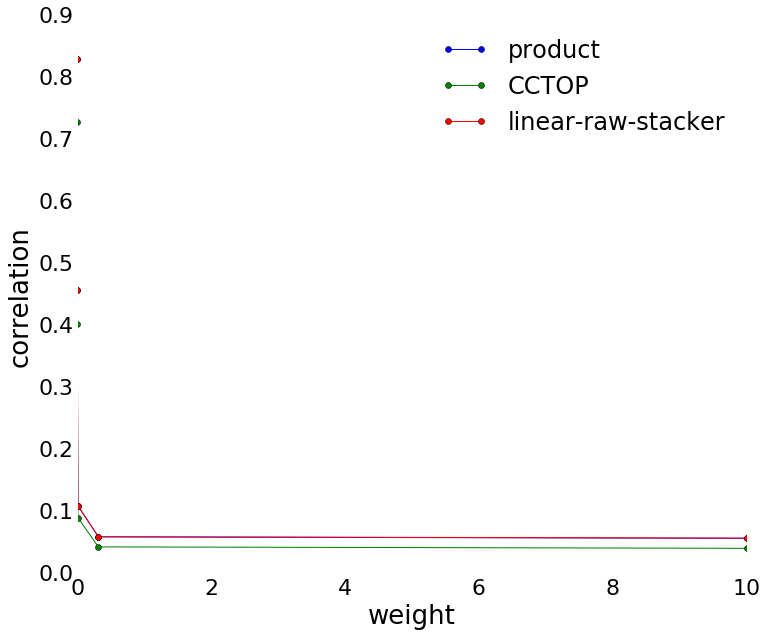

In [152]:
gs_results = pp.plot_spearman_with_different_weights(predictions_flat, truth_all, 
                                                      weights=np.logspace(np.log10(0.00001), np.log10(10), 5))

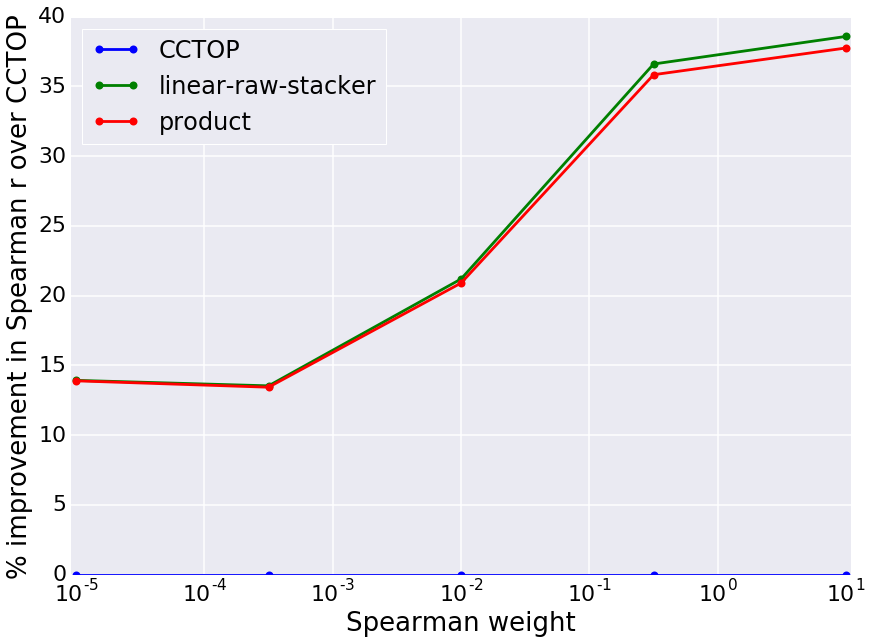

In [153]:
fig = plt.figure(figsize=(14, 10))

x = np.logspace(np.log10(0.00001), np.log10(10), 5)
for m in ['CCTOP', 'linear-raw-stacker', 'product']:
    plt.plot(x, ((np.array(gs_results[m]) -np.array(gs_results['CCTOP']))/np.array(gs_results['CCTOP']))*100., 'o-', 
             label=m, markeredgewidth=0.0, linewidth=2.8, markersize=8)
plt.xscale('log')

# background color
ax = plt.gca()
ax.patch.set_facecolor(background_color)

# grid
plt.grid(color='#ffffff', linestyle='-', linewidth=1.5)
ax.set_axisbelow(True)
a = ax.get_xgridlines()
a[2].set_color(background_color)
a[-1].set_color(background_color)
# legend
plt.legend(loc=0)
lh = ax.get_legend()
lh.legendPatch.set_facecolor(background_color)


#plt.ylim(-0.95, 37)
x_lims = plt.xlim()
plt.xlim((9.0e-6, 1.10*x_lims[1]))

plt.ylabel('% improvement in Spearman r over CCTOP')
plt.xlabel('Spearman weight')

#plt.savefig('plots/improvement_over_CCTOP_Guideseq.pdf')

Loading CFD table from file
Fold 1, Spearman r: product=0.044 HsuZhang=0.055 CCTOP=0.045 CFD=0.058 linear-raw-stacker=0.058 ensemble=0.058 
Fold 1, NDCG k ties: product=0.350 HsuZhang=0.443 CCTOP=0.282 CFD=0.265 linear-raw-stacker=0.436 ensemble=0.632 
Loading CFD table from file
Fold 2, Spearman r: product=0.044 HsuZhang=0.052 CCTOP=0.040 CFD=0.057 linear-raw-stacker=0.057 ensemble=0.057 
Fold 2, NDCG k ties: product=0.602 HsuZhang=0.387 CCTOP=0.368 CFD=0.369 linear-raw-stacker=0.686 ensemble=0.714 
Loading CFD table from file
Fold 3, Spearman r: product=0.046 HsuZhang=0.052 CCTOP=0.039 CFD=0.057 linear-raw-stacker=0.057 ensemble=0.057 
Fold 3, NDCG k ties: product=0.267 HsuZhang=0.446 CCTOP=0.324 CFD=0.415 linear-raw-stacker=0.413 ensemble=0.482 
Loading CFD table from file
Fold 4, Spearman r: product=0.046 HsuZhang=0.055 CCTOP=0.044 CFD=0.058 linear-raw-stacker=0.056 ensemble=0.058 
Fold 4, NDCG k ties: product=0.285 HsuZhang=0.329 CCTOP=0.239 CFD=0.245 linear-raw-stacker=0.363 ense

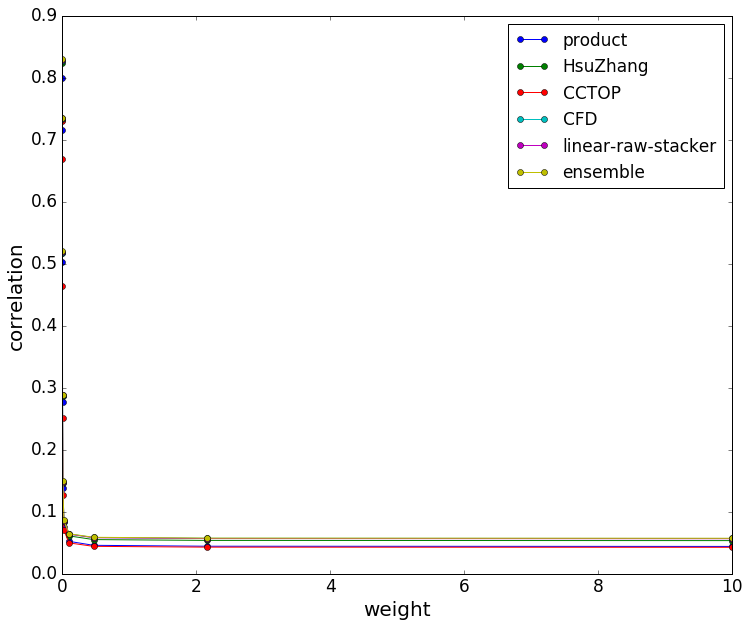

In [108]:
pred_gs_cd33hsu, perf_gs, mismatches_gs, truth_gs_cd33hsu, _, _ = pp.cross_validate_guideseq(guideseq_data,
                                                                            preds_guideseq_cd33hsu,
                                                                            learn_options,
       models= ['CFD', 'HsuZhang', 'CCTOP', 'product', 'linear-raw-stacker', 'ensemble'], n_folds=5)

predictions_flat_cd33hsu = dict([(k, np.concatenate(pred_gs_cd33hsu[k]).flatten()) for k in pred_gs_cd33hsu.keys()])
truth_all_cd33hsu = np.concatenate(truth_gs_cd33hsu).flatten()
gs_results_cd33hsu = pp.plot_spearman_with_different_weights(predictions_flat_cd33hsu, truth_all_cd33hsu, 
                                                      weights=np.logspace(np.log10(0.00001), np.log10(10), 10))

# Base model feature importances

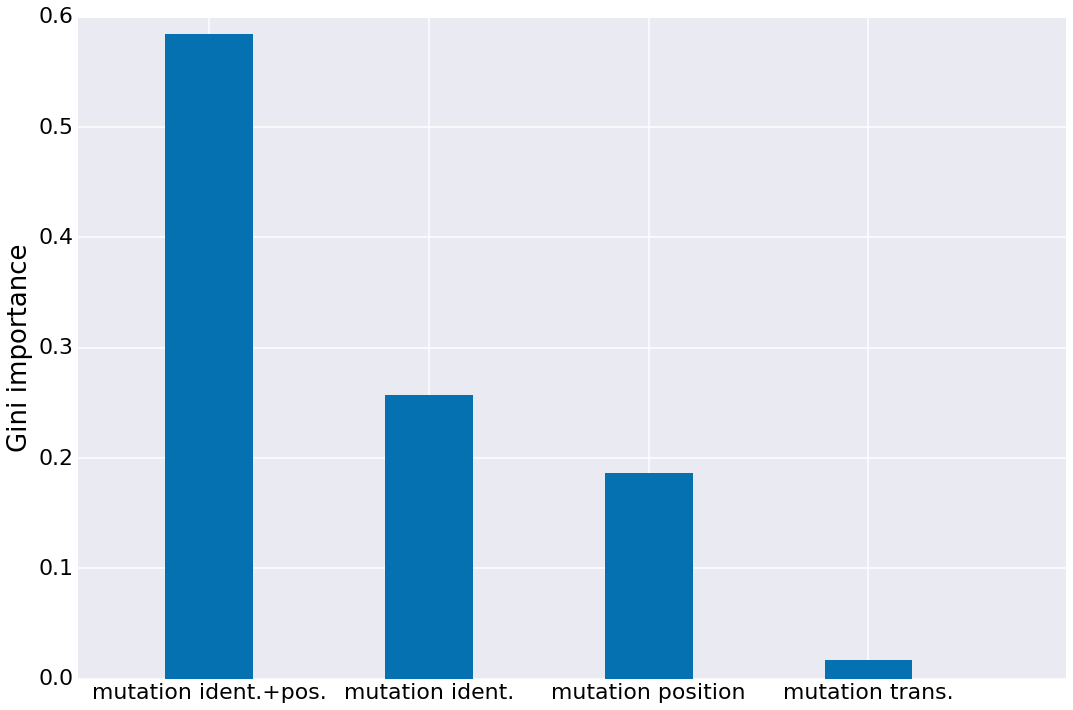

In [27]:
base_feature_names = fnames
feat = pd.DataFrame(index=base_feature_names, data=base_model.feature_importances_, columns=['Gini importance'])
feat_sorted = feat.sort_values(axis=0, ascending=False, by='Gini importance')
feat_sorted_filt = feat_sorted[feat_sorted['Gini importance'] > 0]

feat_sorted.to_excel('plots/base_model_feature_importances.xls')

feature_groups = {'mutation ident.+pos.': [],
                  'mutation ident.': [],
                  'mutation position': [],
                  'mutation trans.': [],
                  'GC content': []}

for f in feat_sorted_filt.index:
    if ":" in f and not "," in f:
        feature_groups['mutation ident.'].append(f)
    elif "pos" in f:
        feature_groups['mutation position'].append(f)
    elif "," in f:
        feature_groups['mutation ident.+pos.'].append(f)
    elif "GC " in f:
        feature_groups['GC content'].append(f)
    elif 'trans' in f or 'translation' in f:
        feature_groups['mutation trans.'].append(f)
    else: # it's a PAM
        feature_groups['mutation ident.'].append(f)
        
names, values = [], []
for fg in feature_groups.keys():
    if feat_sorted_filt.loc[feature_groups[fg]].sum().values[0] > 0:
        names.append(fg)
        values.append(feat_sorted_filt.loc[feature_groups[fg]].sum().values[0])

ind = np.argsort(values)[::-1]
names = np.array(names)[ind]
values = np.array(values)[ind]
# plt.style.use(['seaborn-darkgrid', 'seaborn-paper'])
# plt.style.use(['fivethirtyeight'])
plt.figure(figsize=(15, 10))
w = 0.4
plt.ylabel('Gini importance')
plt.bar(np.arange(len(values))+w, values, w,  color=methods_colors['CCTOP'], edgecolor='none')#methods_colors['CCTOP'])
plt.xticks(np.arange(len(values))+w+w/2, names, rotation=0)
plt.xlim((-0, 4.5))

ax = plt.gca()
ax.patch.set_facecolor(background_color)
plt.grid(color='#ffffff', linestyle='-', linewidth=1.5)
ax.set_axisbelow(True)
a = ax.get_xgridlines()
plt.tight_layout()
#a[2].set_color(background_color)
#a[-1].set_color(background_color)


plt.savefig('plots/base_feature_importances.pdf')

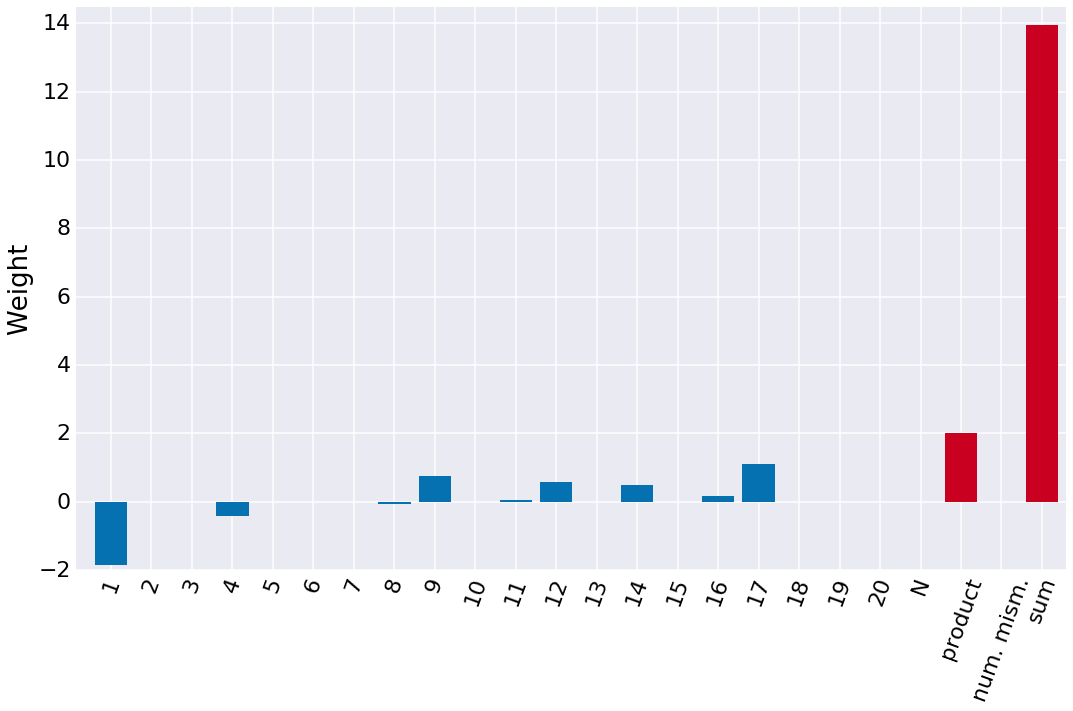

In [31]:
plt.figure(figsize=(15, 10))
coef = stacker_hmg.named_steps['lasso'].coef_
# coef = stacker_hmg.feature_importances_
coef_hmg = coef

meta_coef = coef[-3:]
nucl_coef = coef[:-3]

names = []
for n in feat_hmg:
    if 'pos' in n:
        l = n.replace('pos', '')
        if l == '21':
            l = 'N'
        names.append(l)
    elif 'annotations' in n:
        names.append(n.replace('annotations', 'mism.'))
    else:
        names.append(n)
        
ind = np.arange(len(coef))
width = 0.8
plt.bar(ind[:-3], nucl_coef, width, color=methods_colors['CCTOP'], edgecolor='none')
plt.bar(ind[-3:], meta_coef, width, color=methods_colors['Elevation'],edgecolor='none')
plt.xticks(ind+width/2., names, rotation=70)
#bbox_inches='tight'
plt.tight_layout()
plt.ylabel('Weight')
#plt.xticks(ind[-3:]+width/2., names[-3:], rotation=80)
plt.xlim((-0.5, 24))
plt.ylim((-2.0, 14.5))

# background color
ax = plt.gca()
ax.patch.set_facecolor(background_color)
plt.grid(color='#ffffff', linestyle='-', linewidth=1.5)
ax.set_axisbelow(True)
a = ax.get_xgridlines()
plt.tight_layout()
#a[2].set_color(background_color)
#a[-1].set_color(background_color)
plt.savefig('plots/stacker_feat_importances_train_Haeussler.pdf')

['product', 'num. mism.', 'sum', '', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', 'N']


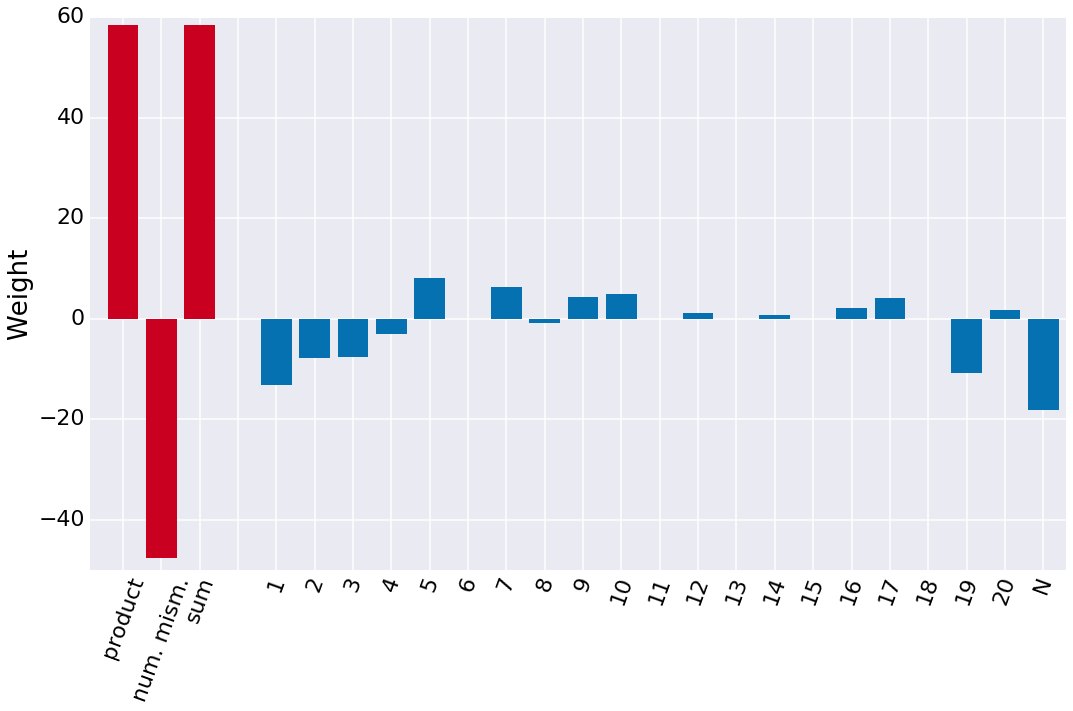

In [149]:
plt.figure(figsize=(15, 10))
coef = stacker_gs.named_steps['lasso'].coef_
coef_gs = coef

meta_coef = coef[-3:]
nucl_coef = coef[:-3]

names = []
for n in feat_gs:
    if 'pos' in n:
        l = n.replace('pos', '')
        if l == '21':
            l = 'N'
        names.append(l)
    elif 'annotations' in n:
        names.append(n.replace('annotations', 'mism.'))
    else:
        names.append(n)
        
ind = np.arange(len(coef)+1) 
width = 0.8
names_new = names[-3:]
names_new.append('')
names_new.extend(names[:-3])
print names_new
names = names_new
plt.bar(ind[4:], nucl_coef, width, color=methods_colors['CCTOP'], edgecolor='none')
plt.bar(ind[:3], meta_coef, width, color=methods_colors['Elevation-score'], edgecolor='none')
plt.xticks(ind+width/2., names, rotation=70)
#bbox_inches='tight'
plt.tight_layout()
plt.ylabel('Weight')
#plt.xticks(ind[-3:]+width/2., names[-3:], rotation=80)
plt.xlim((-0.5, 25))
plt.ylim((-50, 60))
ax = plt.gca()
ax.patch.set_facecolor(background_color)
plt.grid(color='#ffffff', linestyle='-', linewidth=1.5)
ax.set_axisbelow(True)
a = ax.get_xgridlines()
plt.tight_layout()
#a[2].set_color(background_color)
#a[-1].set_color(background_color)
plt.savefig('plots/stacker_feat_importances_train_Guideseq.pdf')

In [148]:
ind[4:].shape

(21,)

(0.0, 61.0)


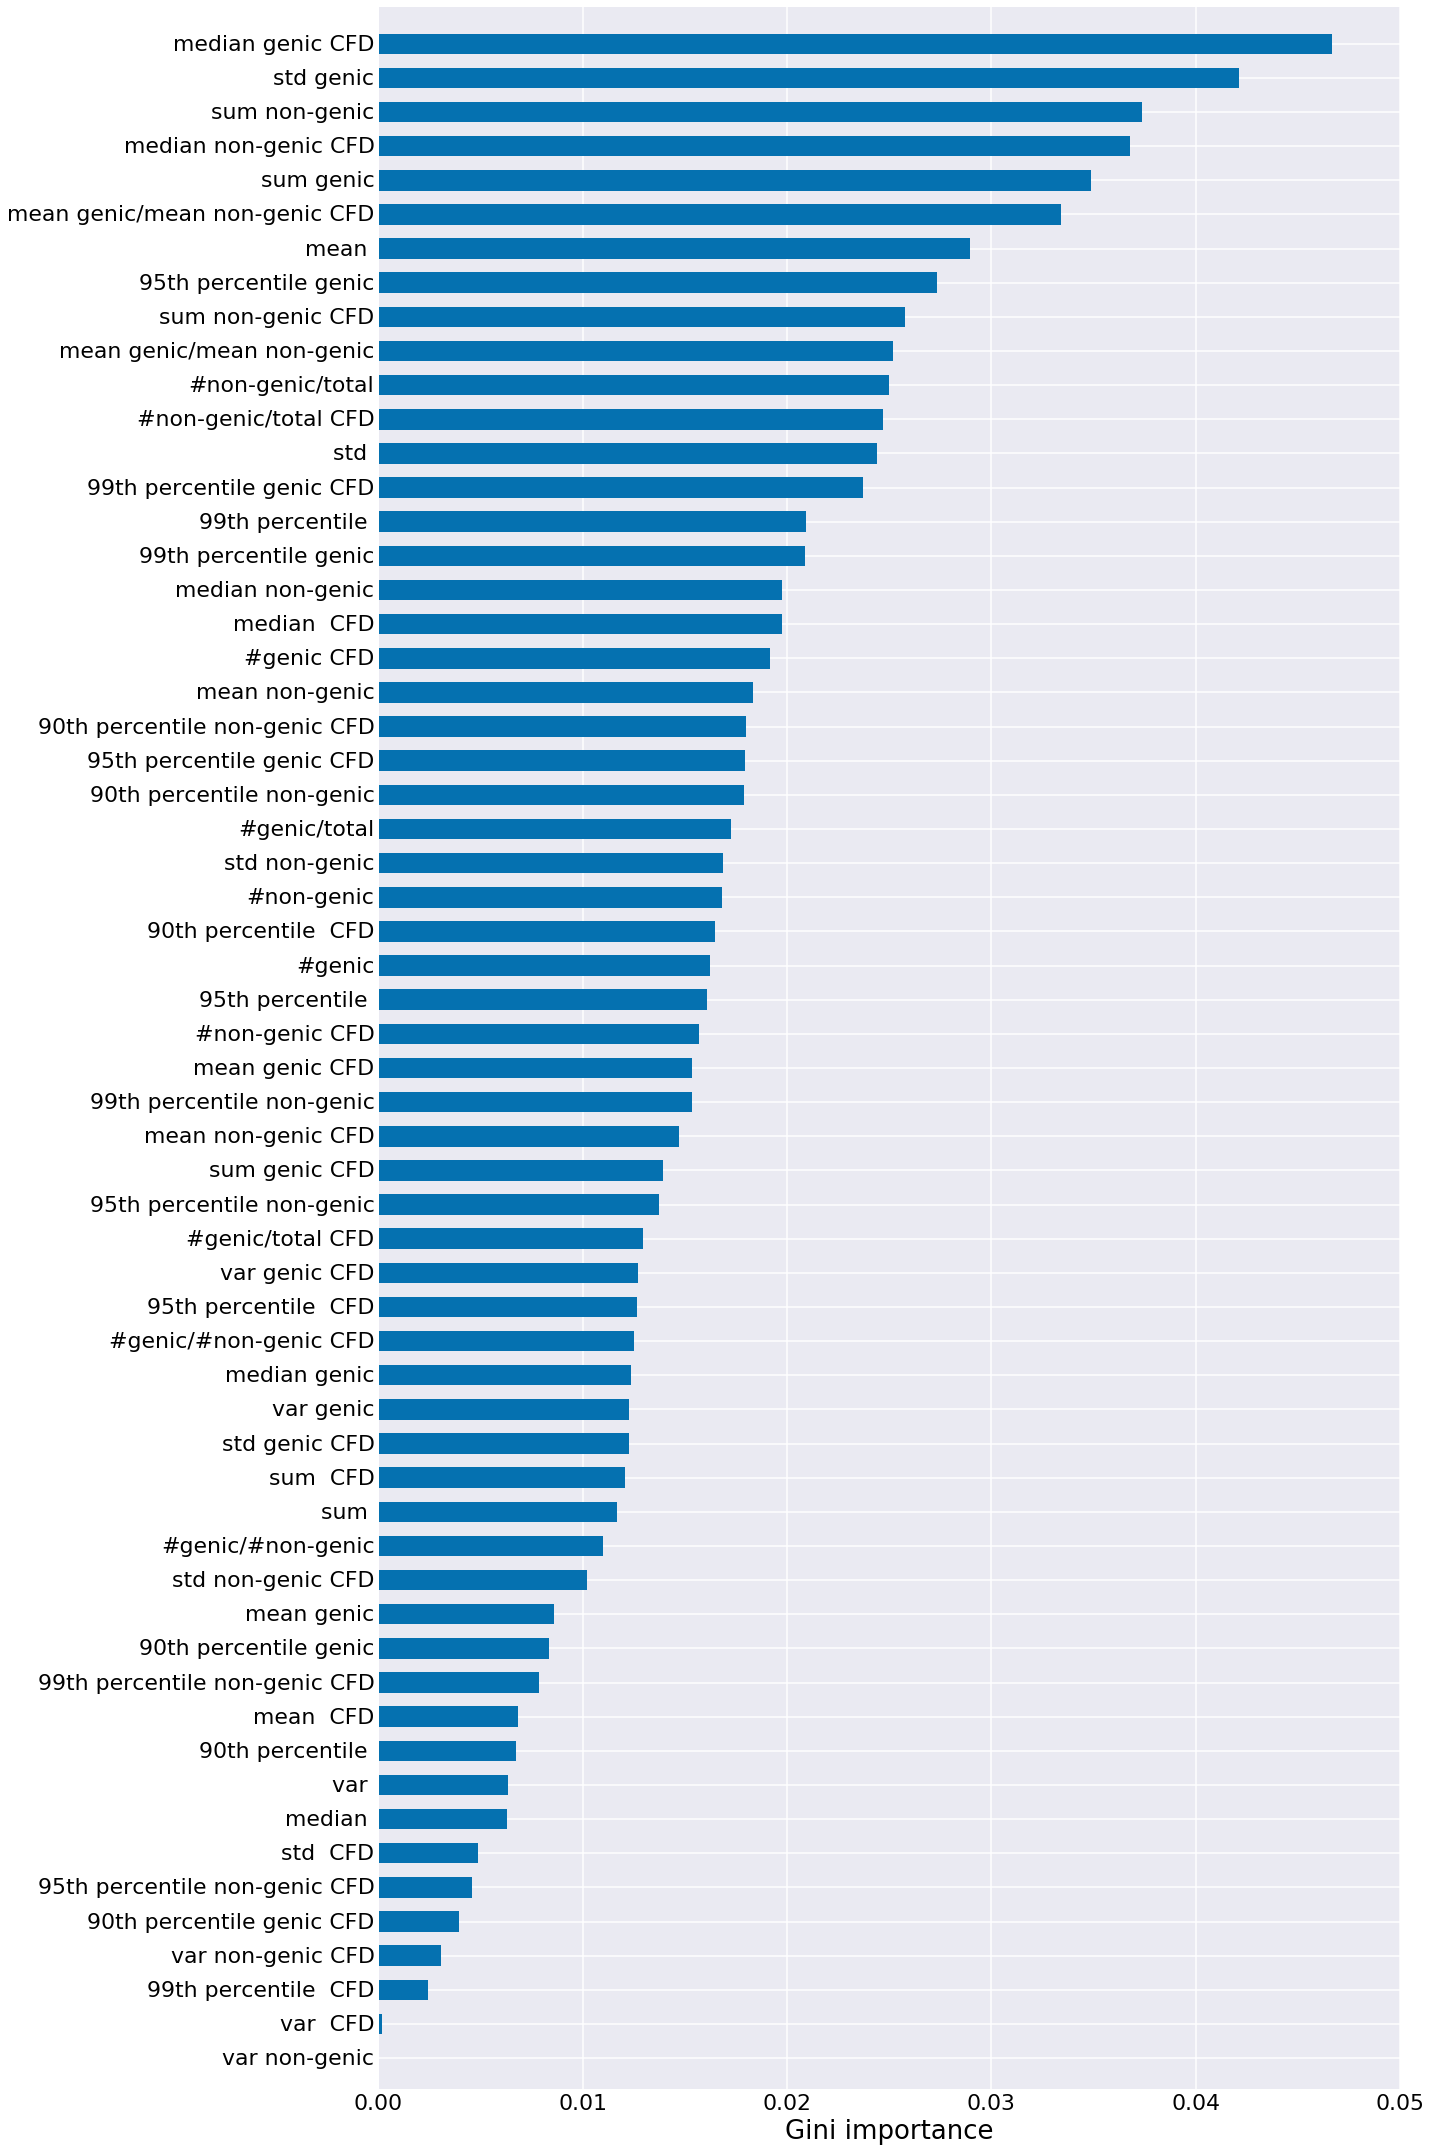

In [161]:
with open('/tmp/aggregation_model.pkl', 'rb') as f:
    aggregator_model, feature_names = pickle.load(f)

new_feature_names = []
for f in feature_names:
    new_feature_names.append(f)
for f in feature_names:
    new_feature_names.append(f + ' CFD')
feature_names = new_feature_names
#feature_names = names
#feature_names = ['mean', 'mean genic', 'mean non-genic', 'std', 'std genic', 'std non-genic',
#                'num.', 'num. genic', 'num. non-genic',
#                'max', 'max genic', 'max non-genic', '95th percentile', '95th percentile genic', '95th percentile non-genic',
#                'median', 'median genic', 'median non-genic']

feat = pd.DataFrame(index=feature_names, data=aggregator_model.feature_importances_, columns=['Gini importance'])
feat_sorted = feat.sort_values(axis=0, ascending=False, by='Gini importance')
feat_sorted_filt = feat_sorted[feat_sorted['Gini importance'] > 0]

feat_sorted.to_excel('plots/aggregator_model_feature_importances.xls')

feature_groups = {'nucleotides': [],
                  'mutation ident.': [],
                  'mutation position': [],
                  'mutation trans.': [],
                  'GC content': []}

names, values = [], []
for f in feat_sorted_filt.index:
    names.append(f)
    values.append(feat_sorted_filt.loc[f].values[0])


ind = np.argsort(values)[::-1]
names = np.array(names)[ind]
values = np.array(values)[ind]
# plt.style.use(['seaborn-darkgrid', 'seaborn-paper'])
# plt.style.use(['fivethirtyeight'])
plt.figure(figsize=(20, 30))
w = 0.6
plt.xlabel('Gini importance')
plt.barh((np.arange(len(values))+w)[::-1], values, w, color=methods_colors['CCTOP'], edgecolor='none')
plt.yticks((np.arange(len(values))+w+w/2)[::-1], names, rotation=0)

# plt.xlim((0.3, 16.5))
# plt.ylim((0.0, 0.19))
ax = plt.gca()
ax.patch.set_facecolor(background_color)
plt.grid(color='#ffffff', linestyle='-', linewidth=1.5)
ax.set_axisbelow(True)
# a = ax.get_xgridlines()
#a[2].set_color(background_color)
#a[-1].set_color(background_color)
plt.tight_layout()
plt.savefig('plots/aggregator_feature_importances.pdf')
print plt.ylim(0.0, 61.0)

product
HsuZhang
broad
CFD
ensemble
linear-raw-stacker
MIT
product
HsuZhang
broad
CFD
ensemble
linear-raw-stacker
MIT
Gecko pv=0.000001, us_corr=0.096468, MIT_corr=-0.029132
Avana pv=0.000000, us_corr=0.190863, MIT_corr=0.064523


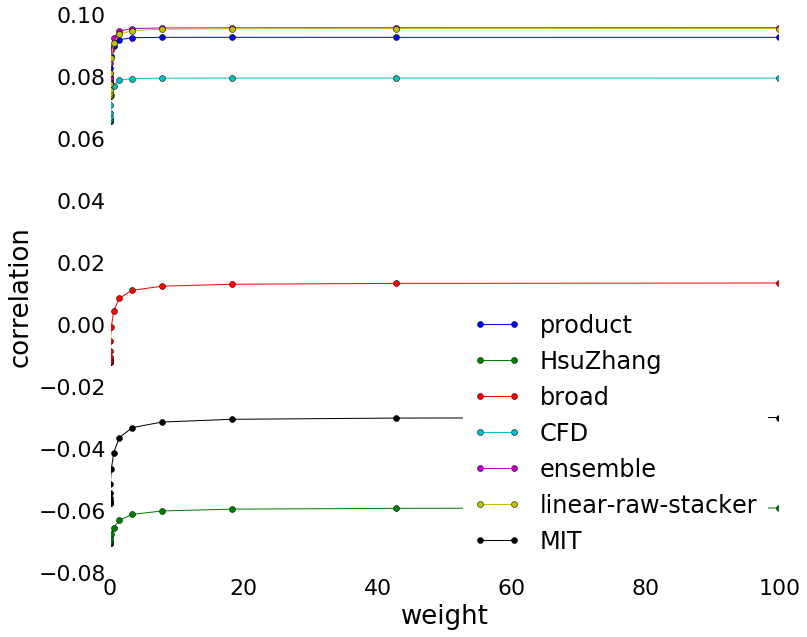

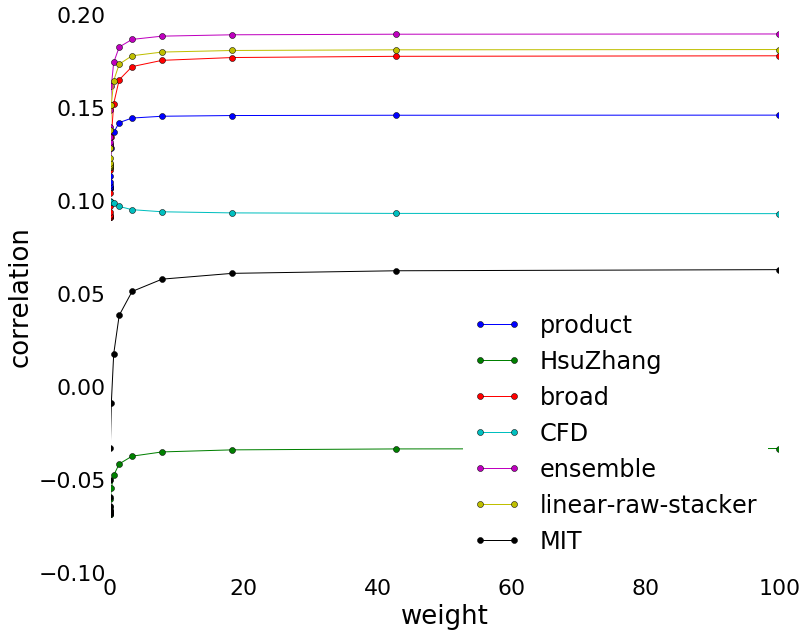

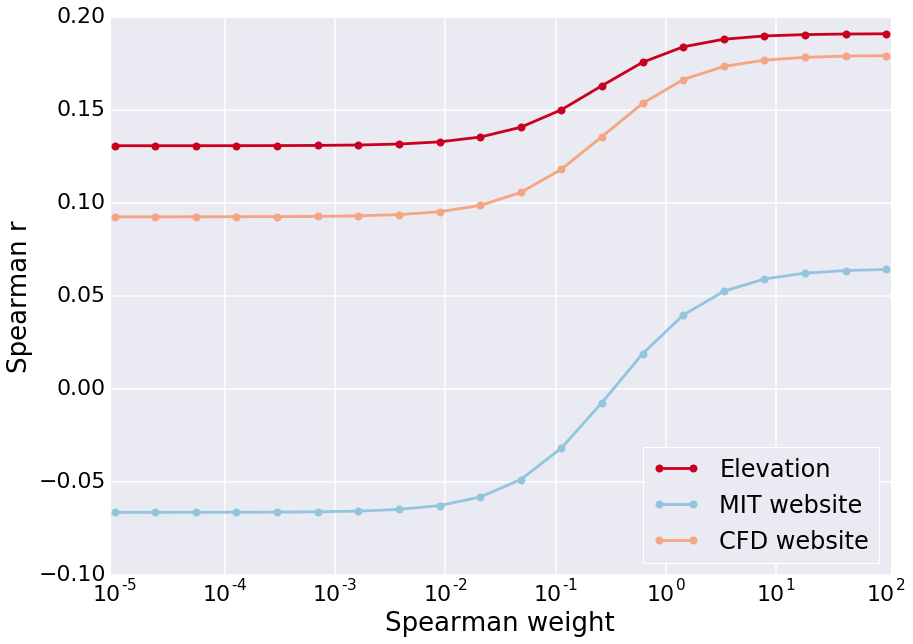

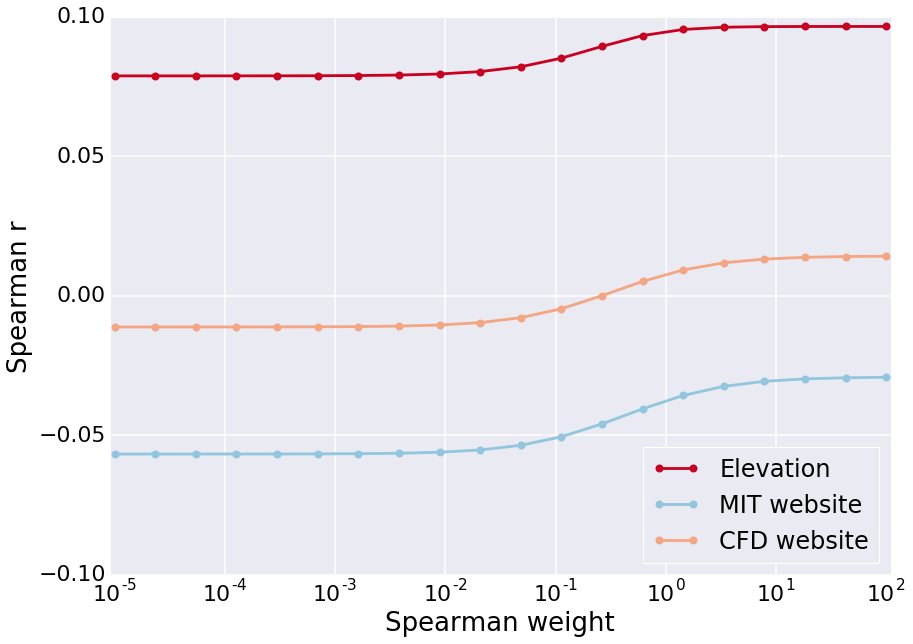

In [156]:
methods_colors_agg = {'CFD website': '#f4a582',
                 'MIT website': '#92c5de',
                 'CCTOP': "#0571b0",
                 'Elevation': '#ca0020',
                 'Elevation-naive': '#92c5de'}

methods_names_agg = {'broad': 'CFD website',
                'MIT': 'MIT website',
                'CCTOP': 'CCTOP',
                'ensemble': 'Elevation',
                'product': 'Elevation-naive'}

with open('/tmp/aggregation_results.pickle', 'rb') as f:
    gecko, avana = pickle.load(f)
[preds_gecko, y_gecko_rank] = gecko
[preds_avana, y_rank] = avana

gecko_results = elevation.prediction_pipeline.plot_spearman_with_different_weights(preds_gecko, y_gecko_rank, 
                                                                    weights=np.logspace(np.log10(0.00001), np.log10(100), 20))

avana_results =  elevation.prediction_pipeline.plot_spearman_with_different_weights(preds_avana, y_rank, 
                                                                    weights=np.logspace(np.log10(0.00001), np.log10(100), 20))


fig = plt.figure(figsize=(14, 10))

x = np.logspace(np.log10(0.00001), np.log10(100), 20)
for m in ['ensemble', 'MIT', 'broad']:
    plt.plot(x, np.array(avana_results[m]), 'o-', label=methods_names_agg[m], 
             color=methods_colors_agg[methods_names_agg[m]], markeredgewidth=0.0, linewidth=2.8, markersize=8)
plt.xscale('log')

# background color
ax = plt.gca()
ax.patch.set_facecolor(background_color)

# grid
plt.grid(color='#ffffff', linestyle='-', linewidth=1.5)
ax.set_axisbelow(True)
a = ax.get_xgridlines()
a[2].set_color(background_color)
a[-1].set_color(background_color)
# legend
plt.legend(loc=4)
lh = ax.get_legend()
lh.legendPatch.set_facecolor(background_color)


# plt.ylim(-0.95, 100)
# plt.ylim(-3., 40)
x_lims = plt.xlim()
plt.xlim((9.0e-6, 1.10*x_lims[1]))

plt.ylabel('Spearman r')
plt.xlabel('Spearman weight')
plt.savefig('plots/aggregation_performance_avana.pdf')


fig = plt.figure(figsize=(14, 10))

x = np.logspace(np.log10(0.00001), np.log10(100), 20)
for m in ['ensemble', 'MIT', 'broad']:
    plt.plot(x, np.array(gecko_results[m]), 'o-', label=methods_names_agg[m], 
             color=methods_colors_agg[methods_names_agg[m]], markeredgewidth=0.0, linewidth=2.8, markersize=8)
plt.xscale('log')

# background color
ax = plt.gca()
ax.patch.set_facecolor(background_color)

# grid
plt.grid(color='#ffffff', linestyle='-', linewidth=1.5)
ax.set_axisbelow(True)
a = ax.get_xgridlines()
a[2].set_color(background_color)
a[-1].set_color(background_color)
# legend
plt.legend(loc=4)
lh = ax.get_legend()
lh.legendPatch.set_facecolor(background_color)


# plt.ylim(-0.95, 100)
# plt.ylim(-3., 40)
x_lims = plt.xlim()
plt.xlim((9.0e-6, 1.10*x_lims[1]))
plt.ylim((-0.10, 0.10))
plt.ylabel('Spearman r')
plt.xlabel('Spearman weight')
plt.savefig('plots/aggregation_performance_gecko.pdf')

t2, pv, corr0, corr1,_ = azimuth.util.get_pval_from_predictions(preds_gecko['ensemble'], 
                                                       preds_gecko['MIT'],  
                                                       y_gecko_rank, 
                                                       twotailed=False, method='steiger')
print "Gecko pv=%f, us_corr=%f, MIT_corr=%f" % (pv, corr0, corr1)

filt = ~np.isnan(preds_avana['MIT'])
t2, pv, corr0, corr1,_ = azimuth.util.get_pval_from_predictions(preds_avana['ensemble'][filt], 
                                                       preds_avana['MIT'][filt],  
                                                       y_rank[filt], 
                                                       twotailed=False, method='steiger')
print "Avana pv=%f, us_corr=%f, MIT_corr=%f" % (pv, corr0, corr1)


In [34]:
with open('base_CFDfeat_predictions.pkl', 'rb') as f:
    preds_guideseq_cfd_feat, individual_mut_pred_roc_cfd_feat = pickle.load(f)

In [35]:
with open('base_classifier_predictions.pkl', 'rb') as f:
    preds_guideseq_class, individual_mut_pred_roc_class = pickle.load(f)

In [36]:
pred_roc_cfd_feat = pp.stacked_predictions(roc_data, individual_mut_pred_roc_cfd_feat, learn_options=learn_options, 
                                       guideseq_data=guideseq_data,
                                       preds_guideseq=preds_guideseq_cfd_feat, 
                                       prob_calibration_model=None,#calibration_models,
                                       models=['product', 'CFD', 'HsuZhang', 'linear-raw-stacker', 'ensemble'],
                                       return_model=False)

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [37]:
pred_roc_class = pp.stacked_predictions(roc_data, individual_mut_pred_roc_class, learn_options=learn_options, 
                                       guideseq_data=guideseq_data,
                                       preds_guideseq=preds_guideseq_class, 
                                       prob_calibration_model=None,#calibration_models,
                                       models=['product', 'CFD', 'HsuZhang', 'linear-raw-stacker', 'ensemble'],
                                       return_model=False)

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [38]:
pred_roc_base_models = {}
pred_roc_base_models['Elevation'] = pred_roc_calibrated['linear-raw-stacker'].copy()
pred_roc_base_models['CCTOP'] = pred_roc_calibrated['CCTOP'].copy()
pred_roc_base_models['Elevation-naive'] = pred_roc_calibrated['product'].copy()
pred_roc_base_models['Elevation-classifier'] = pred_roc_class['product'].copy()
pred_roc_base_models['Elevation-CFDfeat'] = pred_roc_cfd_feat['product'].copy()
# pred_roc_base_models['CFD'] = pred_roc_cfd_feat['product'].copy()

Elevation-classifier
Elevation-naive
Elevation
Elevation-CFDfeat
CCTOP


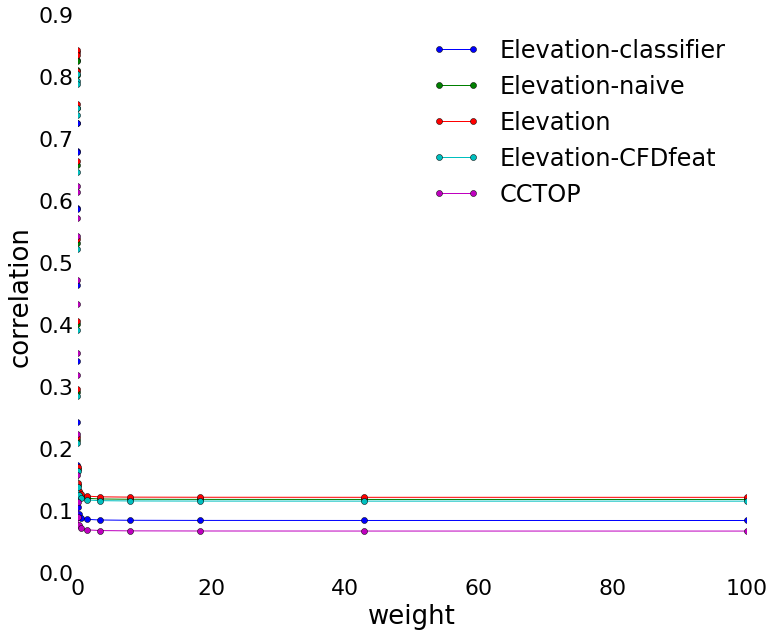

In [39]:
roc_results_base_models = pp.plot_spearman_with_different_weights(pred_roc_base_models, roc_Y_vals.values.flatten(), 
                                                      weights=np.logspace(np.log10(0.00001), np.log10(100), 20))

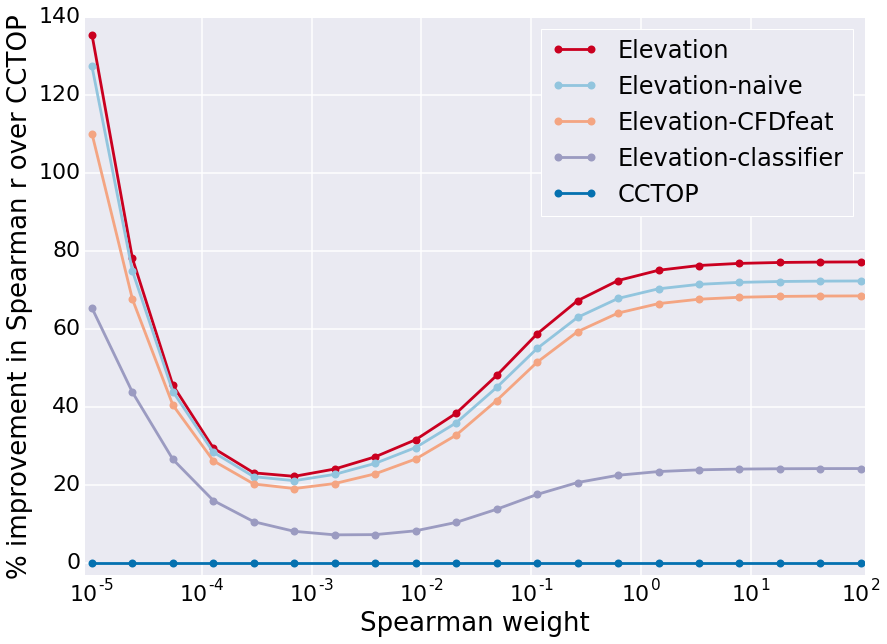

In [40]:
methods_colors_feat = {'Elevation-CFDfeat': '#f4a582',
                     'Elevation-classifier': '#9B9BC1',
                     'CCTOP': "#0571b0",
                     'Elevation': '#ca0020',
                     'Elevation-naive': '#92c5de',
                      }


fig = plt.figure(figsize=(14, 10))

x = np.logspace(np.log10(0.00001), np.log10(100), 20)
for m in ['Elevation', 'Elevation-naive', 'Elevation-CFDfeat', 'Elevation-classifier', 'CCTOP']:#roc_results_base_models.keys():
    plt.plot(x, ((np.array(roc_results_base_models[m]) -np.array(roc_results_base_models['CCTOP']))/np.array(roc_results_base_models['CCTOP']))*100., 'o-', 
            markeredgewidth=0.0, linewidth=2.8, markersize=8, label=m, color=methods_colors_feat[m])
plt.xscale('log')

# background color
ax = plt.gca()
ax.patch.set_facecolor(background_color)

# grid
plt.grid(color='#ffffff', linestyle='-', linewidth=1.5)
ax.set_axisbelow(True)
a = ax.get_xgridlines()
a[2].set_color(background_color)
a[-1].set_color(background_color)


# legend
plt.legend(loc=0)
lh = ax.get_legend()
lh.legendPatch.set_facecolor(background_color)


plt.ylim(-3., 140)
x_lims = plt.xlim()
plt.xlim((8.5e-6, 1.10*x_lims[1]))

plt.ylabel('% improvement in Spearman r over CCTOP')
plt.xlabel('Spearman weight')
plt.savefig('plots/improvement_over_CCTOP_Haeussler_feat_class_elev.pdf')
# plt.title("Haeussler minus GUIDE-Seq")

In [41]:
pred_guideseq_hmg_feat = pp.stacked_predictions(guideseq_data, preds_guideseq_cfd_feat, guideseq_data=hmg,
                                                preds_guideseq=individual_mut_pred_roc_cfd_feat,
                                                prob_calibration_model=None,
                                                learn_options=learn_options,
                                                models=['product', 'CFD', 'HsuZhang', 'linear-raw-stacker', 'ensemble'],
                                                return_model=False,
                                                )

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [ ]:
pred_guideseq_hmg_class = pp.stacked_predictions(guideseq_data, preds_guideseq_class, guideseq_data=hmg,
                                                preds_guideseq=individual_mut_pred_roc_class,
                                                prob_calibration_model=None,
                                                learn_options=learn_options,
                                                models=['product'],
                                                return_model=False,
                                                )

In [ ]:
pred_hmg_base_models = {}
pred_hmg_base_models['elevation'] = pred_guideseq_hmg['product'].copy()
pred_hmg_base_models['CCTOP'] = pred_guideseq_hmg['CCTOP'].copy()
pred_hmg_base_models['elevation-classifier'] = pred_guideseq_hmg_class['product'].copy()
pred_hmg_base_models['elevation-CFDfeat'] = pred_guideseq_hmg_feat['product'].copy()

In [ ]:
gs_results_hmg_base_models = pp.plot_spearman_with_different_weights(pred_hmg_base_models, guideseq_data['GUIDE-SEQ Reads'].values.flatten(), 
                                                      weights=np.logspace(np.log10(0.00001), np.log10(100), 20))

In [ ]:
fig = plt.figure(figsize=(14, 10))

x = np.logspace(np.log10(0.00001), np.log10(100), 20)
for m in roc_results_base_models.keys():
    plt.plot(x, ((np.array(gs_results_hmg_base_models[m]) -np.array(gs_results_hmg_base_models['CCTOP']))/np.array(gs_results_hmg_base_models['CCTOP']))*100., 'o-', 
            markeredgewidth=0.0, linewidth=2.8, markersize=8, label=m)
plt.xscale('log')

# background color
ax = plt.gca()
ax.patch.set_facecolor(background_color)

# grid
plt.grid(color='#ffffff', linestyle='-', linewidth=1.5)
ax.set_axisbelow(True)
a = ax.get_xgridlines()
a[2].set_color(background_color)
a[-1].set_color(background_color)


# legend
plt.legend(loc=0)
lh = ax.get_legend()
lh.legendPatch.set_facecolor(background_color)


plt.ylim(-3., 125)
x_lims = plt.xlim()
plt.xlim((8.5e-6, 1.10*x_lims[1]))

plt.ylabel('% improvement in Spearman r over CCTOP')
plt.xlabel('Spearman weight')

In [65]:
(guideseq_data['GUIDE-SEQ Reads'].values != 0).sum()

354

In [135]:
methods_colors

{'CCTOP': '#0571b0',
 'CFD': '#f4a582',
 'Elevation-naive': '#92c5de',
 'Elevation-score': '#ca0020',
 'HsuZhang': '#92c5de'}